# Imports

In [1]:
import sys
import os

os.chdir('..')

In [2]:
import numpy as np
import torch
import seaborn as sns
import matplotlib as mpl

from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
from src.models.custom_dataset import create_dataloaders
from matplotlib import pyplot as plt
os.chdir('src/models')
from src.models.train_model import train_model
from src.models.eval_model import eval_model
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Patch

# Constants

In [3]:
NUM_CLASSES = 5+1 # including background-class
MODEL_PATH = '../../models/output/model_5_classes_best.pth'
NUM_EPOCHS = 1000
BATCH_SIZE = 64

# Eval model

In [4]:
model = eval_model(model_path=MODEL_PATH,
           dataloader_dir='../../models/output/dataloader_5_classes.pkl',
           num_classes=NUM_CLASSES,)

../../models/output/model_5_classes_best.pth
Model has been loaded!
Creating dataloaders...
Loading  from file...
Done
IoU: 0.5103402137756348


# Show predicts

In [5]:
_, _, test_dataloader = create_dataloaders(dataloader_dir='../../models/output/dataloader_5_classes.pkl')

example_of_preds = []

preds_arrays = np.array(())
mask_arrays = np.array(())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

rand_i = np.random.randint(5, BATCH_SIZE)

with torch.no_grad():
    for i, (images, masks) in enumerate(test_dataloader):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)
        
        preds_arrays = np.append(preds_arrays, torch.flatten(preds).cpu().numpy())
        mask_arrays = np.append(mask_arrays, torch.flatten(masks).cpu().numpy())
        
        for n, img in enumerate(images[rand_i - 5:rand_i]):       
            images = torch.squeeze(img, dim=0).cpu().numpy().transpose(1, 2, 0)
            preds_image = preds[rand_i - 5 + n].cpu().numpy()
            mask_image = torch.squeeze(masks[rand_i - 5 + n], dim=0).cpu().numpy()
            example_of_preds.append([images, preds_image, mask_image])

Loading  from file...
Done


In [6]:
classes = ['0', '1', '2', '3', '4', '5']

cmap = mpl.colormaps['viridis']
class_colors = {}
for cls in range(len(classes)):
    color = cmap(cls / (len(classes)-1))
    class_colors[classes[cls]] = color

legend_elements = []
for cls in classes:
    color = class_colors[cls]
    legend_elements.append(Patch(facecolor=color, edgecolor='black', label=cls))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


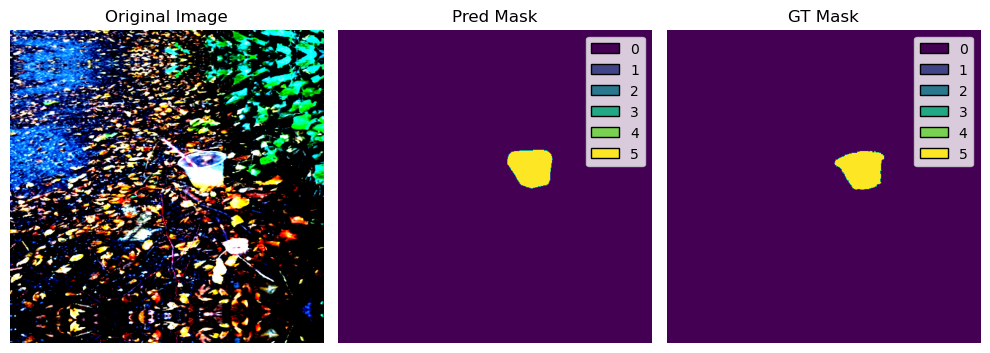

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


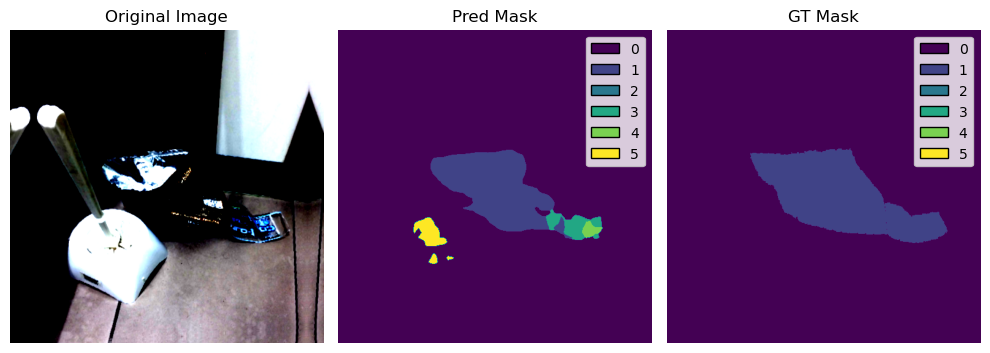

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


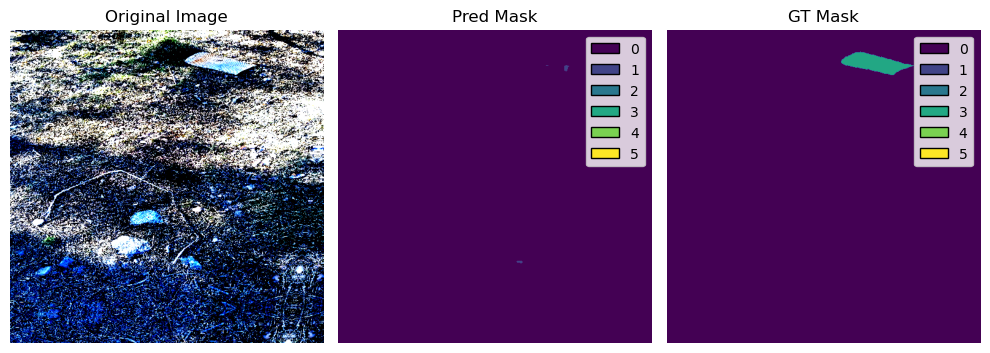

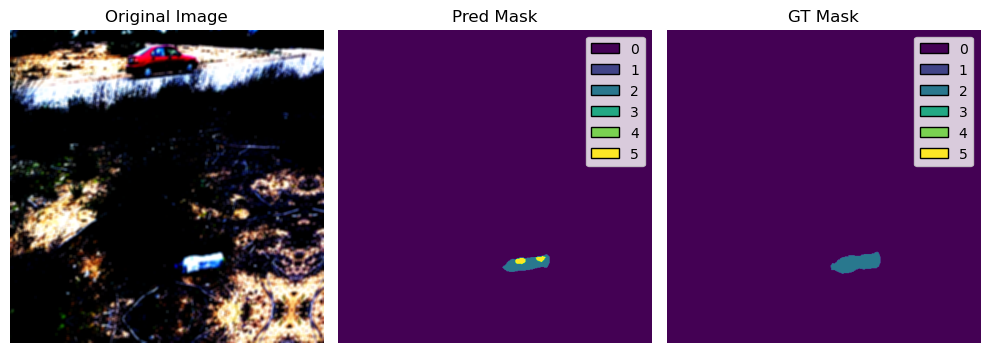

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


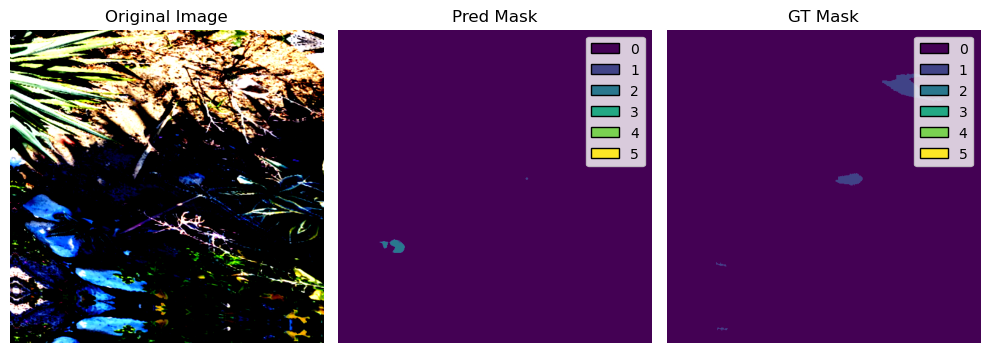

In [7]:
for images, preds_image, mask_image in example_of_preds:
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    
    
    axes[0].imshow(images)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(preds_image, vmin = 0, vmax=NUM_CLASSES - 1)
    axes[1].set_title('Pred Mask')
    axes[1].axis('off')
    
    axes[2].imshow(mask_image, vmin = 0, vmax=NUM_CLASSES - 1)
    axes[2].set_title('GT Mask')
    axes[2].axis('off')

    axes[1].legend(handles=legend_elements)
    axes[2].legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.show()

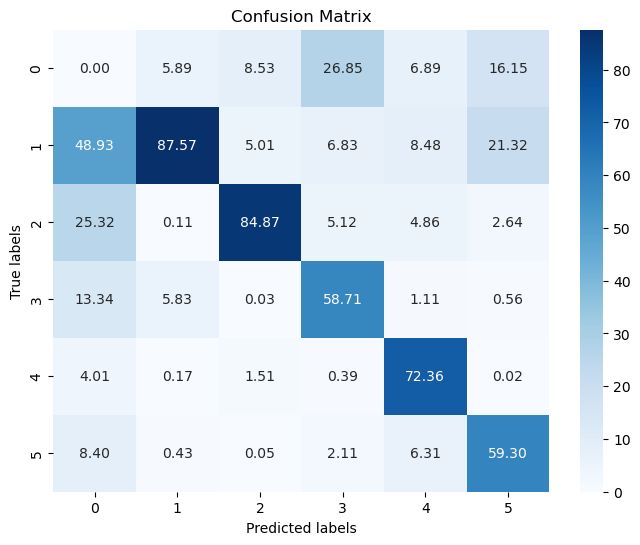

In [8]:
cm = confusion_matrix(mask_arrays, preds_arrays)
cm[0][0] = 0 # ignore 0-class

cm = cm / sum(cm) * 100


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()